# Проект 1799: "Разработка системы предсказания параметров цифровых схем с использованием методов машинного обучения"  
## Первые шаги, в предсказании Площади и Задержки схем

## Подготовка и исследование данных

### Загрузка и очистка от выбросов

In [83]:
import pandas as pd

In [84]:
# Загрузка данных
data = pd.read_csv('data_optimized.csv')

In [85]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13824 entries, 0 to 13823
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   File       13824 non-null  object 
 1   Area       13520 non-null  float64
 2   Delay      13520 non-null  float64
 3   embedding  13520 non-null  object 
dtypes: float64(2), object(2)
memory usage: 432.1+ KB


Видим, что имеются пропуски в значениях т.к. количество ненулевых значений в стобцах Area, Delay и embadding не совпадает с общим числом значений. Значения, которые имеют пропуски в этих ячейках, для обучения не подходят. Очистим данные от пропусков. Важно не забыть, что после использования функции(метода) dropna нумерация будет не последовательной, что может привести к ошибкам в будущем. Стоит сразу же это исправить

In [86]:
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13520 entries, 0 to 13519
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   File       13520 non-null  object 
 1   Area       13520 non-null  float64
 2   Delay      13520 non-null  float64
 3   embedding  13520 non-null  object 
dtypes: float64(2), object(2)
memory usage: 422.6+ KB


Проверим наличие выбросов в значениях параметров Задержки и площади:

In [88]:
print("Максимальная задержка: ", data['Delay'].max())
print("Минимальная задержка: ", data['Delay'].min())
print("Максимальная площадь: ", data['Area'].max())
print("Минимальная площадь: ", data['Area'].min())

Максимальная задержка:  1078.17
Минимальная задержка:  -1000000000.0
Максимальная площадь:  1189.38
Минимальная площадь:  0.0


Видим, что в таблице присутствуют некорректные данные, с площадью равной 0 и устремленным в минус бесконечность временем задержки. Для улучшения качества обучения, необходимо избавиться от таких данных

In [89]:
data.drop(data[data['Delay'] == data['Delay'].min()].index, inplace=True)
data.drop(data[data['Area'] == data['Area'].min()].index, inplace=True)
data.reset_index(drop=True, inplace=True)

In [90]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13092 entries, 0 to 13091
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   File       13092 non-null  object 
 1   Area       13092 non-null  float64
 2   Delay      13092 non-null  float64
 3   embedding  13092 non-null  object 
dtypes: float64(2), object(2)
memory usage: 409.3+ KB


### Проверка корректности данных. Поиск выбросов

В этом месте, необходимо произвести оценку данных. Вывести графическую статистику по Area и Delay. Задача - определить значения, которые являются выбросами и удалить эти строки из DF. Таким образом, данные будут лучше подобраны для обучения

In [91]:
import matplotlib.pyplot as plt # подключаем библиотеку
import numpy as np

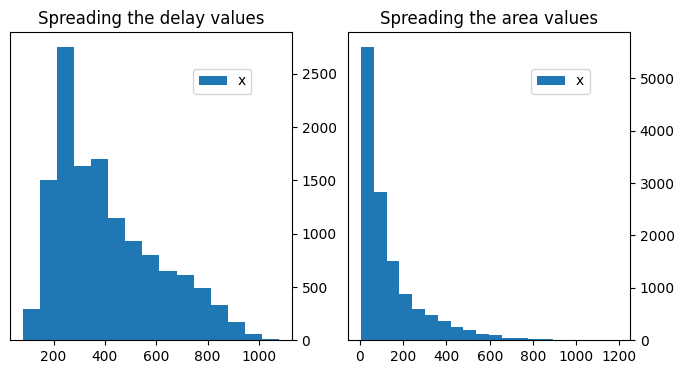

In [92]:
fig, (ax1, ax2) = plt.subplots( #делаем полотно с несколькими графиками
    nrows=1, ncols=2, # расположенными в один ряд два столбца
    figsize=(8, 4) # размер полотна
) #

ax1.hist( # строим второй график - гистограмму
    data['Delay'], bins=15, # задаем данные и диапазоны
    label=('x', 'y') # и подписи данных
)

ax1.legend(loc=(0.65, 0.8)) # отображаем легенду и задаем ее расположение
ax1.set_title('Spreading the delay values') # название второго графика
ax1.yaxis.tick_right() # устанавливаем, что вертикальная ось должна быть справа

ax2.hist( # строим второй график - гистограмму
    data['Area'], bins=20,  # задаем данные и диапазоны
    label=('x', 'y') # и подписи данных
)

ax2.locator_params (axis='x', nbins=10)
ax2.legend(loc=(0.65, 0.8)) # отображаем легенду и задаем ее расположение
ax2.set_title('Spreading the area values') # название второго графика
ax2.yaxis.tick_right() # устанавливаем, что вертикальная ось должна быть справа

plt.show() # отображаем полотна

Видим, что значения задержи, большие 1000 (Если данных будет нехватать, то и большие 750), можно принять за выбросы. Для площади, это значения большие 150.

In [93]:
data.drop(data[data['Delay'] > 1000].index, inplace=True)
data.drop(data[data['Area'] > 600].index, inplace=True)
data.reset_index(drop=True, inplace=True)

In [94]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12845 entries, 0 to 12844
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   File       12845 non-null  object 
 1   Area       12845 non-null  float64
 2   Delay      12845 non-null  float64
 3   embedding  12845 non-null  object 
dtypes: float64(2), object(2)
memory usage: 401.5+ KB


### Парсинг эмбеддингов

In [95]:
data['embedding'][1231]

'[[-0.0023294328711926937, 0.0010059750638902187, 0.020557958632707596, 0.036383241415023804, -0.0376126691699028, -0.028824374079704285, 0.025990357622504234, 0.03626422584056854, -0.02031301148235798, -0.01526272390037775, 0.029781151562929153, -0.006153405643999577, -0.01836802251636982, 0.026345035061240196, -0.01960602030158043, -0.007308585569262505, 0.011734742671251297, 0.004220206756144762, -0.03347805514931679, -0.03825681284070015, 0.02961454726755619, 0.020517736673355103, 0.027350598946213722, 0.0030764532275497913, 0.025808831676840782], [-0.013696731068193913, -0.003834116505458951, 0.023253051564097404, -0.030173856765031815, -0.01584583893418312, -0.030236484482884407, -0.0036846150178462267, 0.03843872249126434, -0.02941228821873665, -0.009418928995728493, -0.007723821792751551, 0.032445743680000305, -0.023836053907871246, 0.00016100586799439043, -0.019183043390512466, -0.038594264537096024, 0.020150167867541313, -0.03511103242635727, -0.017706187441945076, -0.0001177

Видим, что эмбеддинги для каждой схемы хранятся в формате string, что не подходит для обучения моделей. Необходимо, преобразовать их в то, чем они являются изначально.  
Напишем программу, которая приведет текстовое представление данных к list, который будет содержать numpy массивы  
Для начала, напишем функцию, которая будет проверять, можно ли приобразовать строку в дробное число (записано ли в строке число)


In [96]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

Далее, напишем функцию, которая распарсит нашу строку на list, который будет содержать numpy массивы

In [97]:
new_embedding = []
for str in data['embedding']:
    result = []
    if '\n' in str:
        res = str.split('\n')
    else:
        res = str.split('], ')
    for mass in res:
        s = mass.replace(', dtype=float32',' ').replace('(', ' ').replace(')',' ').replace(',',' ').replace('[','').replace(']','').split(' ')
        tmp = []
        for word in s:
            if is_number(word):
                tmp.append(float(word))
        result.append(tmp)
    r = [np.array(sublist) for sublist in result]
    new_embedding.append(r)

### Приведение данных в вид, удобный для обучения

Так как каждая схема имеет свое представление в виде графа, возникла проблема, что каждая схема представлена разным количеством векторов длины 4. Т.е. каждая схема описанна массивом, содержащим в себе *n*ое количество массивов длины 4. Так как в процессе обучения, нам требуется, чтобы размерность данных для каждой схемы была единой, то нужно чем-то и до какого-то числа дополнить данные о каждой схеме.  
Идеи:  
* Находим схему, которая представлена в виде максимального количества векторов. Дополняем все остальные схемы до данной размерности
* Дополняем векторами, состоящими из нулей
* Дополняем векторами, состоящими из чисел, являющимися средним значением по всей выборке (средними значениями координат векторов)
* Дополняем векторами, состоящими из чисел, являющимися средним значением по схемам, имеющим наибольшее число векторов в представлении

В данный момент, были реализованы и проверены идеи с дополнением средним значением по всему датасету и дополнение 0. Различия по точности отсутствуют

Ниже, представлена реализация дополнения до размерности максимальной из схем, векторами, состоящими из 0


In [98]:
max_subarrays = max(len(arr) for arr in new_embedding)

for i in range(len(new_embedding)):
    while len(new_embedding[i]) < max_subarrays:
        new_embedding[i] = np.vstack([new_embedding[i], np.zeros(25)])

Ниже, представленна реализация дополнения до размерности максимальной из схем векторами, состоящими из средних значений по всей выборке

In [99]:
#lst = []
#for i in new_embedding:
#    for k in i:
#        lst.append(k.mean())
#val = np.array(lst).mean()

In [100]:
#max_subarrays = max(len(arr) for arr in new_embedding)
#
#for i in range(len(new_embedding)):
#    while len(new_embedding[i]) < max_subarrays:
#        new_embedding[i] = np.vstack([new_embedding[i], np.full(25, val)])

Так как для большей части алгоритмов машинного обучения данные, представленные в формате двумерного массива не подходят, необходимо, привести их в удобоваримый вид.  
Идеи:  
* Запишем все имеющиеся в представлении вектора друг за другом, по порядку, по которому они хранятся изначально
* Запишем все имеющиеся в представлении вектора друг за другом, перемешав их произвольным образом

Ниже, реализован способ, с записыванием вектором друг за другом в исходном порядке   

In [101]:
for i in range(len(new_embedding)):
    tmp = []
    for j in range (len(new_embedding[i])):
        for k in new_embedding[i][j]:
            tmp.append(k)
    new_embedding[i] = np.array(tmp)

Добавим в наш датасет новый столбец, содержащий уже преобразованные вектора

In [102]:
s = pd.Series(new_embedding)
data['New_embeddings'] = s

Теперь, наши данные выглядят следующим образом

In [103]:
data['New_embeddings']

0        [-0.0021449089981615543, 0.000945725420024246,...
1        [-0.0021449089981615543, 0.000945725420024246,...
2        [-0.002141991164535284, 0.0009532237891107798,...
3        [-0.0021485977340489626, 0.0009492258541285992...
4        [-0.0021652388386428356, 0.0009332413319498301...
                               ...                        
12840    [-0.0021476016845554113, 0.0009556888835504651...
12841    [-0.002182498574256897, 0.0009277667268179357,...
12842    [-0.0022188432049006224, 0.0009272933239117265...
12843    [-0.0021463329903781414, 0.0009479891159571707...
12844    [-0.002146391198039055, 0.0009560753242112696,...
Name: New_embeddings, Length: 12845, dtype: object

## Подготовка и обучение моделей

### Крайний этап обработки данных

Загрузить данные в виде одного столбца нашей исходной таблицы и обучать модели на них - нельзя, из-за требований моделей к формату предсавления обучающей выборки. Поэтому, преобразуем наши данные в таблицу

In [104]:
tmp = pd.DataFrame(data['New_embeddings'].values.tolist(), index = data['New_embeddings'].index)
tmp

,0,1,2,3,4,5,6,7,8,9,...,3515,3516,3517,3518,3519,3520,3521,3522,3523,3524
0,-0.002145,0.000946,0.020413,0.036037,-0.037212,-0.028467,0.025835,0.035892,-0.020062,-0.015053,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.002145,0.000946,0.020413,0.036037,-0.037212,-0.028467,0.025835,0.035892,-0.020062,-0.015053,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.002142,0.000953,0.020416,0.036037,-0.037219,-0.028467,0.025838,0.035897,-0.020057,-0.015059,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.002149,0.000949,0.020408,0.036037,-0.037204,-0.028466,0.025836,0.035890,-0.020067,-0.015046,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.002165,0.000933,0.020422,0.036041,-0.037203,-0.028482,0.025853,0.035888,-0.020088,-0.015040,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12840,-0.002148,0.000956,0.020448,0.036086,-0.037270,-0.028437,0.025885,0.035904,-0.020207,-0.015110,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12841,-0.002182,0.000928,0.020423,0.036001,-0.037197,-0.028509,0.025925,0.035998,-0.020073,-0.015123,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12842,-0.002219,0.000927,0.020497,0.036098,-0.037358,-0.028552,0.025927,0.036067,-0.020229,-0.015152,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12843,-0.002146,0.000948,0.020416,0.036038,-0.037214,-0.028468,0.025836,0.035893,-0.020064,-0.015057,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Обучение моделей для предсказания параметра 'Area'
Далее, разделим данные на X - матрица объекты-признаки и y - указания учителя  

In [105]:
# Данные, для которых будем проводить нормализацию
X = tmp
# Данные, для которых не будем проводить нормализацию
X_0 = tmp
#Целевые параметры. Разделим их, для возможных экспериментов с ними в будущем
y = data['Area']
y_0 = data['Area']

Проведем нормализацию данных

In [106]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = scaler.fit_transform(X)

Разделим данные на тренировочные и тестовые

In [107]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X_0_train, X_0_test, y_0_train, y_0_test = train_test_split(X_0, y_0, test_size=0.20, random_state=42)

### Выбор, настройка и обучение моделей

### Градиентный бустинг

In [108]:
from sklearn.ensemble import GradientBoostingRegressor
gb_regressor = GradientBoostingRegressor(learning_rate=0.075, 
                                         n_estimators=500, 
                                         max_features='sqrt', 
                                         random_state=10)
gb_regressor.fit(X_train, y_train)

# Оценка качества модели на тестовых данных
accuracy = gb_regressor.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.9827798711731877


Параметр *accuracy* рассчитывается с помощью метода score объекта GradientBoostingRegressor. В случае регрессии этот метод возвращает коэффициент детерминации (R²), который является мерой качества регрессионной модели.
Коэффициент детерминации (R²) рассчитывается по следующей формуле: R^2 = 1 - SS(res)/SS(tot), где
SS(res) - сумма квадратов остатков (остаточная сумма квадратов), которая представляет собой сумму квадратов разностей между фактическими значениями и предсказанными значениями.
SS(tot) - общая сумма квадратов, которая представляет собой сумму квадратов разностей между фактическими значениями и средним значением фактических значений.

In [109]:
from sklearn.metrics import mean_absolute_error

# Предсказание на тестовых данных
y_pred = gb_regressor.predict(X_test)

# Рассчет средней абсолютной ошибки
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Рассчет относительной ошибки
relative_error = mae / abs(y_test.mean())
print("Relative Error:", relative_error)

Mean Absolute Error (MAE): 11.989869453434768
Relative Error: 0.09718084339384711


In [110]:
#Обучение без нормализации
gb_regressor_0 = GradientBoostingRegressor(learning_rate=0.01, 
                                         n_estimators=500, 
                                         max_features='sqrt', 
                                         random_state=10)
gb_regressor_0.fit(X_0_train, y_0_train)

# Оценка качества модели на тестовых данных
accuracy_0 = gb_regressor_0.score(X_0_test, y_0_test)
print("Accuracy:", accuracy_0)

Accuracy: 0.9817962040034501


In [111]:
# Предсказание на тестовых данных
y_0_pred = gb_regressor_0.predict(X_0_test)

# Рассчет средней абсолютной ошибки
mae_0 = mean_absolute_error(y_0_test, y_0_pred)
print("Mean Absolute Error (MAE):", mae_0)

# Рассчет относительной ошибки
relative_error_0 = mae_0 / abs(y_0_test.mean())
print("Relative Error:", relative_error_0)

Mean Absolute Error (MAE): 12.423316622396161
Relative Error: 0.10069403939735126


### Случайный лес

На данный момент, присутствуют трудности с подбором параметров (при некоторых значениях модель обучается бесконечно долго) Вполне возможно, что нет необходимости использовать данную модель. Необходимо дальнейшее углубление в принципы работы данной модели и работа с гиперпараметрами

In [112]:
#from sklearn.ensemble import RandomForestRegressor

#rf_regressor = RandomForestRegressor(n_estimators=200, random_state=0, oob_score=True)

#rf_regressor.fit(X_train, y_train)

#accuracy = rf_regressor.score(X_test, y_test)
#print("Accuracy:", accuracy)


### Метод опорных векторов

На данный момент, присутствуют трудности с подбором параметров (при некоторых значениях модель обучается бесконечно долго) Вполне возможно, что нет необходимости использовать данную модель. Необходимо дальнейшее углубление в принципы работы данной модели и работа с гиперпараметрами

In [113]:
#from sklearn.svm import SVR

#svm_regressor = SVR()

#param_grid = { 'C':[0.1,1,100,1000],'kernel':['rbf','poly','sigmoid','linear'],'degree':[1,2,3,4,5,6],'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

#grid = GridSearchCV(SVR(),param_grid)

#grid.fit(X_train,y_train)

#print(grid.best_params_)
#print(grid.score(X_test,y_test))

### Нейронная сеть

In [114]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Dense(512, activation='tanh', input_shape=(X_train.shape[1],)),
    Dense(512, activation='tanh'),
    Dense(128, activation='tanh'),
    Dense(128, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(32, activation='tanh'),
    Dense(1)  
])


model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(X_train, y_train, epochs=150, validation_split=0.2)

loss, mae = model.evaluate(X_test, y_test)
print("Mean Absolute Error on test data:", mae)

Epoch 1/150
257/257 [==============================] - 1s 5ms/step - loss: 28141.0312 - mae: 113.9540 - val_loss: 28119.1602 - val_mae: 110.6877
Epoch 2/150
257/257 [==============================] - 1s 5ms/step - loss: 27662.4980 - mae: 112.0494 - val_loss: 28226.7891 - val_mae: 112.4503
Epoch 3/150
257/257 [==============================] - 1s 6ms/step - loss: 26133.3438 - mae: 107.5915 - val_loss: 25489.9941 - val_mae: 102.3223
Epoch 4/150
257/257 [==============================] - 1s 4ms/step - loss: 23736.8301 - mae: 99.0037 - val_loss: 23940.8223 - val_mae: 97.4568
Epoch 5/150
257/257 [==============================] - 1s 5ms/step - loss: 22296.0918 - mae: 93.8055 - val_loss: 22577.0195 - val_mae: 92.1387
Epoch 6/150
257/257 [==============================] - 1s 5ms/step - loss: 21051.8184 - mae: 89.5758 - val_loss: 21392.1836 - val_mae: 88.2352
Epoch 7/150
257/257 [==============================] - 1s 5ms/step - loss: 19940.6973 - mae: 85.9549 - val_loss: 20329.9043 - val_mae: 8

In [115]:
# Получение прогнозов модели на тестовых данных
y_pred = model.predict(X_test).flatten() 

# Рассчет относительной ошибки
relative_error = mae / np.abs(np.mean(y_test))
print("Relative Error on test data:", relative_error)

81/81 [==============================] - 0s 2ms/step
Relative Error on test data: 0.11239430925011241


In [116]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

model_0 = Sequential([
    Dense(512, activation='tanh', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_0_train.shape[1],)),
    Dropout(0.5),
    Dense(512, activation='tanh', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(128, activation='tanh', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(128, activation='tanh', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(64, activation='tanh', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(1)  
])

model_0.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

history_0 = model_0.fit(X_0_train, y_0_train, epochs=150, validation_split=0.2)

loss_0, mae_0 = model_0.evaluate(X_0_test, y_0_test)
print("Mean Absolute Error on test data:", mae_0)

Epoch 1/150
257/257 [==============================] - 3s 10ms/step - loss: 29592.7441 - mae: 119.7636 - val_loss: 29204.4062 - val_mae: 114.8651
Epoch 2/150
257/257 [==============================] - 2s 9ms/step - loss: 27313.0586 - mae: 110.5033 - val_loss: 26997.0020 - val_mae: 106.3210
Epoch 3/150
257/257 [==============================] - 2s 9ms/step - loss: 24840.8750 - mae: 101.6952 - val_loss: 24503.3359 - val_mae: 97.7867
Epoch 4/150
257/257 [==============================] - 2s 9ms/step - loss: 22598.0762 - mae: 94.7175 - val_loss: 22267.9629 - val_mae: 91.7918
Epoch 5/150
257/257 [==============================] - 2s 9ms/step - loss: 20451.5137 - mae: 88.7515 - val_loss: 19889.8262 - val_mae: 81.0189
Epoch 6/150
257/257 [==============================] - 2s 9ms/step - loss: 18098.1914 - mae: 78.8743 - val_loss: 17586.6133 - val_mae: 72.6085
Epoch 7/150
257/257 [==============================] - 2s 9ms/step - loss: 16184.0215 - mae: 72.5343 - val_loss: 15558.8418 - val_mae: 6

In [117]:
# Получение прогнозов модели на тестовых данных
y_pred_0 = model_0.predict(X_0_test).flatten() 

# Рассчет относительной ошибки
relative_error_0 = mae_0 / np.abs(np.mean(y_0_test))
print("Relative Error on test data:", relative_error_0)

81/81 [==============================] - 0s 2ms/step
Relative Error on test data: 0.13550374060131384


## Обучение моделей для предсказания параметра 'Delay'
Далее, разделим данные на X - матрица объекты-признаки и y - указания учителя  

In [118]:
# Данные, для которых будем проводить нормализацию
X1 = tmp
# Данные, для которых не будем проводить нормализацию
X1_0 = tmp
#Целевые параметры. Разделим их, для возможных экспериментов с ними в будущем
y1 = data['Area']
y1_0 = data['Area']

Проведем нормализацию данных

In [119]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X1_0 = scaler.fit_transform(X1_0)

Разделим данные на тренировочные и тестовые

In [120]:
from sklearn.model_selection import train_test_split

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.20, random_state=42)

X1_0_train, X1_0_test, y1_0_train, y1_0_test = train_test_split(X1_0, y1_0, test_size=0.20, random_state=42)

### Выбор, настройка и обучение моделей

### Градиентный бустинг

In [121]:
from sklearn.ensemble import GradientBoostingRegressor
gb_regressor1 = GradientBoostingRegressor(learning_rate=0.01, 
                                         n_estimators=500, 
                                         max_features='sqrt', 
                                         random_state=10)
gb_regressor1.fit(X1_train, y1_train)

# Оценка качества модели на тестовых данных
accuracy1 = gb_regressor1.score(X1_test, y1_test)
print("Accuracy:", accuracy1)

Accuracy: 0.9817962040034501


In [122]:
#Нормализованные данные
from sklearn.ensemble import GradientBoostingRegressor
gb_regressor1_0 = GradientBoostingRegressor(learning_rate=0.01, 
                                         n_estimators=500, 
                                         max_features='sqrt', 
                                         random_state=10)
gb_regressor1_0.fit(X1_0_train, y1_0_train)

# Оценка качества модели на тестовых данных
accuracy1_0 = gb_regressor1_0.score(X1_0_test, y1_0_test)
print("Accuracy:", accuracy1_0)

Accuracy: 0.9818564715830892


### Нейронная сеть

In [124]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model1 = Sequential([
    Dense(512, activation='tanh', input_shape=(X_train.shape[1],)),
    Dense(512, activation='tanh'),
    Dense(128, activation='tanh'),
    Dense(128, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(32, activation='tanh'),
    Dense(1)  
])


model1.compile(optimizer='adam', loss='mse', metrics=['mae'])

history1 = model1.fit(X1_train, y1_train, epochs=150, validation_split=0.2)

loss1, mae1 = model1.evaluate(X1_test, y1_test)
print("Mean Absolute Error on test data:", mae1)

Epoch 1/150
257/257 [==============================] - 1s 5ms/step - loss: 28272.0625 - mae: 114.2931 - val_loss: 28291.4336 - val_mae: 111.3018
Epoch 2/150
257/257 [==============================] - 1s 5ms/step - loss: 26416.4316 - mae: 107.0080 - val_loss: 26576.7109 - val_mae: 104.8557
Epoch 3/150
257/257 [==============================] - 1s 4ms/step - loss: 24820.3516 - mae: 101.1851 - val_loss: 25060.2949 - val_mae: 99.6302
Epoch 4/150
257/257 [==============================] - 1s 4ms/step - loss: 23405.4902 - mae: 96.5528 - val_loss: 23720.6543 - val_mae: 95.5530
Epoch 5/150
257/257 [==============================] - 1s 5ms/step - loss: 22147.9102 - mae: 92.9938 - val_loss: 22517.1895 - val_mae: 92.4307
Epoch 6/150
257/257 [==============================] - 1s 4ms/step - loss: 21037.6621 - mae: 90.2830 - val_loss: 21466.6777 - val_mae: 90.0563
Epoch 7/150
257/257 [==============================] - 1s 4ms/step - loss: 20063.9746 - mae: 88.4116 - val_loss: 20542.0273 - val_mae: 88

In [125]:
# Получение прогнозов модели на тестовых данных
y_pred1 = model1.predict(X1_test).flatten() 

# Рассчет относительной ошибки
relative_error1 = mae1 / np.abs(np.mean(y1_test))
print("Relative Error on test data:", relative_error1)

81/81 [==============================] - 0s 2ms/step
Relative Error on test data: 0.12321497551325813


In [ ]:
#С нормализованными данными
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model1_0 = Sequential([
    Dense(512, activation='tanh', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_0_train.shape[1],)),
    Dropout(0.5),
    Dense(512, activation='tanh', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(128, activation='tanh', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(128, activation='tanh', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(64, activation='tanh', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(1)  
])


model1_0.compile(optimizer='adam', loss='mse', metrics=['mae'])

history1_0 = model1_0.fit(X1_0_train, y1_0_train, epochs=150, validation_split=0.2)

loss1_0, mae1_0 = model1_0.evaluate(X1_0_test, y1_0_test)
print("Mean Absolute Error on test data:", mae1_0)

Epoch 1/150
257/257 [==============================] - 2s 6ms/step - loss: 19822.3555 - mae: 89.8614 - val_loss: 9087.3896 - val_mae: 51.8883
Epoch 2/150
257/257 [==============================] - 2s 6ms/step - loss: 6481.2202 - mae: 51.3850 - val_loss: 2807.3643 - val_mae: 30.2326
Epoch 3/150
257/257 [==============================] - 1s 6ms/step - loss: 4531.9175 - mae: 46.0402 - val_loss: 1710.3677 - val_mae: 23.7171
Epoch 4/150
257/257 [==============================] - 1s 6ms/step - loss: 3662.5806 - mae: 40.9554 - val_loss: 1350.5211 - val_mae: 23.3604
Epoch 5/150
257/257 [==============================] - 1s 6ms/step - loss: 3618.4011 - mae: 40.7366 - val_loss: 1119.0070 - val_mae: 20.9407
Epoch 6/150
257/257 [==============================] - 1s 6ms/step - loss: 3383.4805 - mae: 38.9653 - val_loss: 1110.2501 - val_mae: 21.3211
Epoch 7/150
257/257 [==============================] - 2s 6ms/step - loss: 3150.4136 - mae: 37.5324 - val_loss: 990.8906 - val_mae: 20.3274
Epoch 8/150
2

In [ ]:
# Получение прогнозов модели на тестовых данных
y_pred1_0 = model.predict(X1_0_test).flatten() 

# Рассчет относительной ошибки
relative_error1_0 = mae1_0 / np.abs(np.mean(y1_0_test))
print("Relative Error on test data:", relative_error1_0)